In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
# Enable inline plots for Jupyter Notebook
%matplotlib inline
plt.style.use('ggplot')

In [3]:
# Rename files to ensure a consistent naming convention
folder = 'brain_tumor_dataset/yes/'
count = 1
for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print("All files in yes dir are renamed")

All files in yes dir are renamed


In [5]:
# Rename files to ensure a consistent naming convention
folder = 'brain_tumor_dataset/no/'
count = 1
for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print("All files in no dir are renamed")

All files in no dir are renamed


# EDA - Exploratory Data Analysis

Plot

In [203]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

150
73


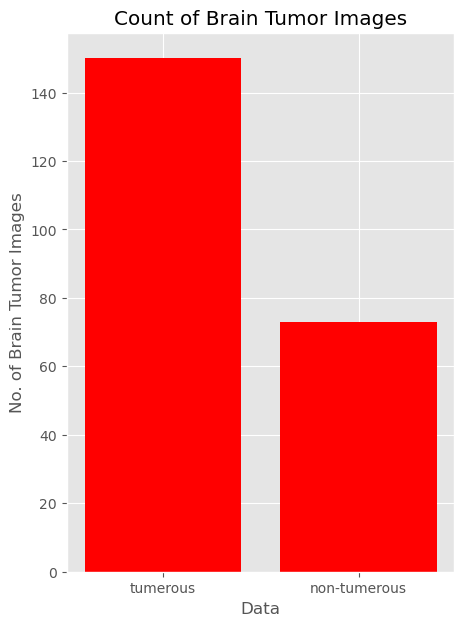

In [18]:
# Create a dictionary with the number of tumorous and non-tumorous images
data = {'tumerous': number_files_yes, 'non-tumerous': number_files_no}

typex = data.keys()
values = data.values()

# Plot the dataset distribution to visualise imbalance
fig = plt.figure(figsize=(5,7))
plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("No. of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# Data Augmentation
Dataset: 150(67%), 73(33%)

In [18]:
import tensorflow as tf
# Import TensorFlow/Keras modules for image augmentation and deep learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
# Load the VGG19 model as the base for transfer learning
from tensorflow.keras.applications.vgg19 import VGG19
# Optimizers for model training
from tensorflow.keras.optimizers import Adam
# Callbacks for saving model, early stopping, and learning rate adjustments
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [42]:
# Generates augmented images to artificially expand the dataset
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    # Initialize the ImageDataGenerator with various augmentation techniques
    data_gen = ImageDataGenerator(
        rotation_range=10,          # Randomly rotate images by ±10 degrees
        width_shift_range=0.1,      # Randomly shift images horizontally by 10%
        height_shift_range=0.1,     # Randomly shift images vertically by 10%
        shear_range=0.1,            # Apply shear transformation
        brightness_range=(0.3, 1.0), # Adjust brightness within the range
        horizontal_flip=True,       # Flip images horizontally
        vertical_flip=True,         # Flip images vertically
        fill_mode='nearest'         # Fill empty pixels with nearest pixel values
    )

    # Iterate through each image file in the directory
    for filename in os.listdir(file_dir):
        # Read the image from file
        image = cv2.imread(file_dir + '/' + filename)

        # Reshape the image to add a batch dimension (required for ImageDataGenerator)
        image = image.reshape((1,) + image.shape) 

        # Create a unique prefix for saved augmented images
        save_prefix = 'aug_' + filename[:-4]  # Removes file extension from filename
        
        i = 0  # Counter for tracking the number of generated images
        
        # Generate augmented images using the data generator
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                   save_prefix=save_prefix, save_format="jpg"):
            i += 1
            # Stop generating once the required number of augmented samples is reached
            if i > n_generated_samples:
                break

In [108]:
# Apply augmentation function and save into new directory
yes_path = 'brain_tumor_dataset/yes'
no_path = 'brain_tumor_dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=13, save_to_dir=augmented_data_path+'no')

0:1:36.61464810371399


In [109]:
# Function to output summary of new dataset
def data_summary(main_path):
    yes_path = 'augmented_data/yes/'
    no_path = 'augmented_data/no/'

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of samples: {n}")
    print(f"{n_pos}: Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg}: Number of negative sample in percentage: {neg_per}%")

In [349]:
data_summary(augmented_data_path)

Number of samples: 2071
1050: Number of positive sample in percentage: 50.70014485755674%
1021: Number of negative sample in percentage: 49.29985514244326%


In [260]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1050
1021


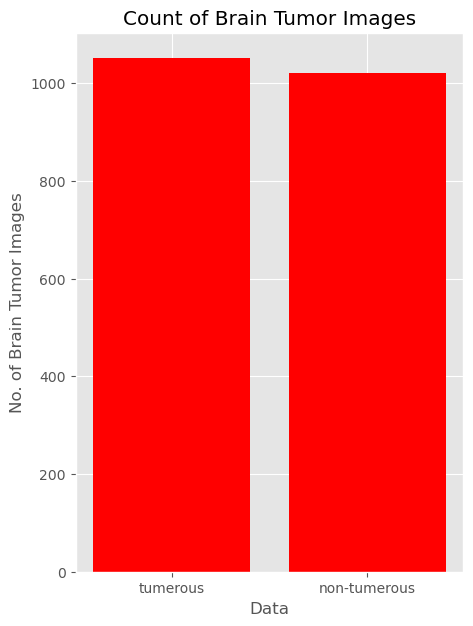

In [112]:
# Create a dictionary with the number of tumorous and non-tumorous images
data = {'tumerous': number_files_yes, 'non-tumerous': number_files_no}

typex = data.keys()
values = data.values()
# Plot the dataset distribution to visualise new balanced augmented dataset
fig = plt.figure(figsize=(5,7))
plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("No. of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# Data Preprocessing

In [114]:
import imutils
# Crops the region of interest (ROI) containing a brain tumor from an MRI scan.
def crop_brain_tumor(image):
    # Convert the image to grayscale for better thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to smooth the image and reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply thresholding to highlight the tumor region (binary mask)
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    # Erode the thresholded image to remove small noise
    thres = cv2.erode(thres, None, iterations=2)

    # Dilate the eroded image to restore tumor shape after erosion
    thres = cv2.dilate(thres, None, iterations=2)
    
    # Find contours of the thresholded binary image
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # If no contours are found, return the original image
    if not cnts:
        return image

    # Select the largest contour (assumed to be the tumor)
    c = max(cnts, key=cv2.contourArea)

    # Find extreme points of the largest contour (bounding box)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])   # Leftmost point
    extRight = tuple(c[c[:, :, 0].argmax()][0])  # Rightmost point
    extTop = tuple(c[c[:, :, 1].argmin()][0])    # Topmost point
    extBot = tuple(c[c[:, :, 1].argmax()][0])    # Bottommost point

    # Crop the original image based on extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    return new_image


In [122]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

valid_extensions = (".jpg")

# Apply image cropping
for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    # Ignore non-image files like .DS_Store
    if not filename.lower().endswith(valid_extensions):
        print(f"⚠️ Skipping Non-Image File: {img_path}")
        continue
    img = crop_brain_tumor(img)
    cv2.imwrite(folder1 + filename, img)
    
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    # Ignore non-image files like .DS_Store
    if not filename.lower().endswith(valid_extensions):
        print(f"⚠️ Skipping Non-Image File: {img_path}")
        continue
    img = crop_brain_tumor(img)
    cv2.imwrite(folder2 + filename, img)

⚠️ Skipping Non-Image File: augmented_data/no/.DS_Store
⚠️ Skipping Non-Image File: augmented_data/no/.DS_Store


In [128]:
from sklearn.utils import shuffle

valid_extensions = (".jpg")

# Loads image data from multiple directories, resizes them, normalizes pixel values, and assigns labels based on the directory name.
def load_data(dir_list, image_size):
    X = []  # List to store image data
    y = []  # List to store labels

    image_width, image_height = image_size  # Extract width and height from tuple

    # Iterate through each directory in the provided list
    for directory in dir_list:
        for filename in os.listdir(directory):
            # Ignore non-image files like .DS_Store
            if not filename.lower().endswith(valid_extensions):
                print(f"⚠️ Skipping Non-Image File: {filename}")
                continue
            
            # Construct the full image path
            img_path = os.path.join(directory, filename)
            
            # Read the image using OpenCV
            image = cv2.imread(img_path)

            # Resize image to the specified dimensions using bicubic interpolation for better quality
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)

            # Normalize pixel values to range [0,1] by dividing by 255.0
            image = image / 255.0  

            # Append the processed image to the dataset
            X.append(image)

            # Assign labels based on the folder name (assumes "yes" for tumor, "no" for non-tumor)
            if directory[-3:].lower() == "yes":  # Ensure case insensitivity
                y.append(1)  # Tumor class
            else:
                y.append(0)  # Non-tumor class

    # Convert lists to numpy arrays for compatibility with deep learning models
    X = np.array(X)
    y = np.array(y)

    # Shuffle dataset to ensure random order of samples
    X, y = shuffle(X, y)

    # Print dataset information for verification
    print(f"Number of examples: {len(X)}")
    print(f"X shape: {X.shape}")  # Shape of image dataset
    print(f"y shape: {y.shape}")  # Shape of label dataset

    return X, y  # Return image data and corresponding labels

In [ ]:
# Calls load_data function
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))
# Accidenatlly cleared cell output

# Data splitting

In [247]:
# The following splits the datat into train, test and validation directories, 80% 10% 10% respectively

In [321]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

Tumorous

In [324]:
files = [f for f in os.listdir('augmented_data/yes/') if not f.startswith(".")]
fnames = []
for i in range(0,842):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [325]:
files = [f for f in os.listdir('augmented_data/yes/') if not f.startswith(".")]
fnames = []
for i in range(842,946):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [327]:
files = [f for f in os.listdir('augmented_data/yes/') if not f.startswith(".")]
fnames = []
for i in range(946,1050):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [330]:
print(f"Train: {len(os.listdir(infected_train_dir))}")
print(f"Test: {len(os.listdir(infected_test_dir))}")
print(f"Validation: {len(os.listdir(infected_valid_dir))}")

Train: 842
Test: 104
Validation: 104


Non-Tumorous

In [333]:
files = [f for f in os.listdir('augmented_data/no/') if not f.startswith(".")]
fnames = []
for i in range(0,817):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [334]:
files = [f for f in os.listdir('augmented_data/no/') if not f.startswith(".")]
fnames = []
for i in range(817,919):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [336]:
files = [f for f in os.listdir('augmented_data/no/') if not f.startswith(".")]
fnames = []
for i in range(919,1021):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

In [339]:
print(f"Train: {len(os.listdir(healthy_train_dir))}")
print(f"Test: {len(os.listdir(healthy_test_dir))}")
print(f"Validation: {len(os.listdir(healthy_valid_dir))}")


Train: 817
Test: 102
Validation: 102


# Model Building

In [20]:
# Define data augmentation transformations for training data
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')

# Normalise validation and test data without augmentation
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [36]:
# Load and preprocess the training dataset with data augmentation
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/',  # Path to training images
                                                    batch_size=32,  # Number of images per batch
                                                    target_size=(240,240),  # Resize images to match model input dimensions
                                                    class_mode='categorical',  # Use categorical labels (multi-class classification)
                                                    shuffle=True,  # Shuffle images to improve training generalization
                                                    seed=42,  # Ensure reproducibility of image shuffling
                                                    color_mode='rgb'  # Load images in RGB format
                                                )

Found 1659 images belonging to 2 classes.


In [38]:
# Load the test dataset (No data augmentation, used for evaluation only)
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', 
                                                   batch_size=32, 
                                                   target_size=(240,240), 
                                                   class_mode='categorical',
                                                   shuffle=False,  # Do NOT shuffle test data to maintain consistency
                                                   seed = 42, 
                                                   color_mode = 'rgb')

Found 206 images belonging to 2 classes.


In [40]:
# Load the validation dataset (Used to tune hyperparameters)
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', 
                                                    batch_size=32, 
                                                    target_size=(240,240), 
                                                    class_mode='categorical',
                                                    shuffle=False,  # Do NOT shuffle test data to maintain consistency
                                                    seed = 42, 
                                                    color_mode = 'rgb')

Found 206 images belonging to 2 classes.


In [28]:
# Creates class name dict
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [356]:
# Load the pre-trained VGG19 model without the fully connected (top) layers
# This allows us to use VGG19 as a feature extractor while adding our own classification head
base_model = VGG19(input_shape=(240, 240, 3), include_top=False, weights='imagenet')

# Freeze all convolutional layers in the base model to retain the pretrained ImageNet features
# Only the newly added layers will be trained initially
for layer in base_model.layers:
    layer.trainable = False

# Define the fully connected classification head (custom top layers)
x = base_model.output
flat = Flatten()(x)  # Flatten feature maps into a 1D vector
class_1 = Dense(1024, activation='relu')(flat)  # First fully connected layer with ReLU activation
drop_out = Dropout(0.3)(class_1)  # Dropout to prevent overfitting
class_2 = Dense(256, activation='relu')(drop_out)  # Second fully connected layer with ReLU activation
output = Dense(2, activation='softmax')(class_2)  # Output layer for binary classification (tumor vs. non-tumor)

# Combine the base model (VGG19) with the custom classification head
model_01 = Model(base_model.input, output)  


2025-03-15 19:33:20.150811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


80134624/80134624 [==============================] - 2s 0us/step


In [358]:
model_01.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [78]:
# Define callbacks to improve training efficiency
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath='model_baseline.h5', monitor='val_loss', verbose=1, save_best_only=True)
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

In [362]:
# Define the Adam optimizer with a specific learning rate
adam = Adam(learning_rate=0.0003)

# Compile the model with:
# - Categorical Crossentropy: Suitable for multi-class classification
# - Adam Optimizer: Efficient adaptive learning rate optimization
# - Accuracy as the evaluation metric
model_01.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [364]:
# Train the model using the training dataset and validate with the validation dataset
history_01 = model_01.fit(
    train_generator,  # Training data generator with augmented images
    steps_per_epoch=10,  # Number of batches per epoch (adjusted based on dataset size)
    epochs=20,  # Number of full passes through the training data
    callbacks=[es, cp, lrr],  # Apply callbacks for early stopping, checkpoint saving, and learning rate reduction
    validation_data=valid_generator  # Use validation data to monitor performance during training
)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 2.2647 - accuracy: 0.4938
Epoch 1: val_loss improved from inf to 1.35588, saving model to model.h5
10/10 [==============================] - 113s 12s/step - loss: 2.2647 - accuracy: 0.4938 - val_loss: 1.3559 - val_accuracy: 0.4951 - lr: 3.0000e-04
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 1.1904 - accuracy: 0.5469
Epoch 2: val_loss improved from 1.35588 to 0.96187, saving model to model.h5
10/10 [==============================] - 108s 11s/step - loss: 1.1904 - accuracy: 0.5469 - val_loss: 0.9619 - val_accuracy: 0.4951 - lr: 3.0000e-04
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.5500
Epoch 3: val_loss improved from 0.96187 to 0.76119, saving model to model.h5
10/10 [==============================] - 103s 11s/step - loss: 0.8919 - accuracy: 0.5500 - val_loss: 0.7612 - val_accuracy: 0.5340 - lr: 3.0000e-04
Epoch 4/20
10/10 [=============================

In [98]:
from tensorflow.keras.models import load_model

model_01 = load_model("model_baseline.h5")

In [100]:
# Evaluate the baseline model on the validation dataset
baseline_valid_eval = model_01.evaluate(valid_generator)  # Returns loss and accuracy

# Evaluate the baseline model on the test dataset (completely unseen data)
baseline_test_eval = model_01.evaluate(test_generator)

# Print evaluation results to compare validation and test performance
print(f'Validation Loss: {baseline_valid_eval[0]}')  # Loss measures how well the model is minimizing error
print(f'Validation Acc: {baseline_valid_eval[1]}')  # Accuracy measures correct predictions on validation set
print(f'Testing Loss: {baseline_test_eval[0]}')  # Loss on completely unseen test data
print(f'Testing Acc: {baseline_test_eval[1]}')  # Accuracy on the test dataset


7/7 [==============================] - 40s 6s/step - loss: 0.4788 - accuracy: 0.8204
Validation Loss: 0.5281327366828918
Validation Acc: 0.737864077091217
Testing Loss: 0.4788374900817871
Testing Acc: 0.8203883767127991


In [114]:
# Add results to dictionary to keep track of improvements and for analysis at the end
results_dict = {"validation": {}, "test": {}}

results_dict["validation"]["baseline"] = baseline_valid_eval
results_dict["test"]["baseline"] = baseline_test_eval

In [62]:
# Generate predictions from the model
baseline_prediction = model_01.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred = np.argmax(baseline_prediction, axis=1)
y_true = test_generator.classes # Actual labels

7/7 [==============================] - 38s 5s/step


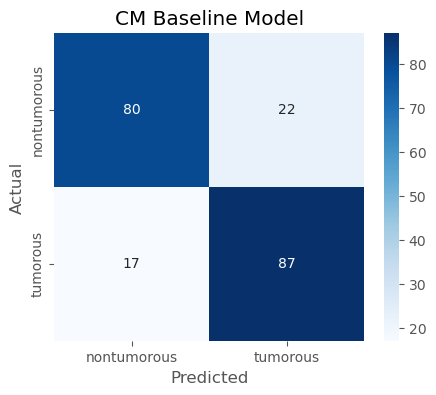

In [237]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CM Baseline Model")
plt.savefig("confusion_matrix_baseline.png", dpi=300, bbox_inches="tight")
plt.show()

In [70]:
# Load the pretrained baseline model to avoid redefining layers from scratch
# This allows us to continue fine-tuning from where we left off
model_02 = load_model("model_baseline.h5")

# Unfreeze specific layers in Block 5 for fine-tuning
set_trainable = False
for layer in model_02.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']: 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [72]:
model_02.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [74]:
# Define a new Adam optimizer with an even lower learning rate for fine-tuning
adam2 = Adam(learning_rate=0.00001) # Lower LR prevents drastic weight updates
model_02.compile(optimizer=adam2, loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
# Change filepath as to not overwrite previous model
cp = ModelCheckpoint(filepath="model_finetuned_stage1.h5", monitor='val_loss', verbose=1, save_best_only=True)

In [80]:
history_02 = model_02.fit(
    train_generator,
    steps_per_epoch=10, 
    epochs=10, # The number of epochs are adjusted for fine-tuning
    validation_data=valid_generator,
    callbacks=[es, cp, lrr]
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.5297 - accuracy: 0.7143
Epoch 1: val_loss improved from inf to 0.51565, saving model to model.h5
10/10 [==============================] - 112s 11s/step - loss: 0.5297 - accuracy: 0.7143 - val_loss: 0.5157 - val_accuracy: 0.7476 - lr: 1.0000e-05
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.7344
Epoch 2: val_loss improved from 0.51565 to 0.47201, saving model to model.h5
10/10 [==============================] - 108s 11s/step - loss: 0.5368 - accuracy: 0.7344 - val_loss: 0.4720 - val_accuracy: 0.7621 - lr: 1.0000e-05
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.5183 - accuracy: 0.7500
Epoch 3: val_loss did not improve from 0.47201
10/10 [==============================] - 108s 11s/step - loss: 0.5183 - accuracy: 0.7500 - val_loss: 0.4803 - val_accuracy: 0.7621 - lr: 1.0000e-05
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.5336 - 

In [106]:
model_02 = load_model("model_finetuned_stage1.h5")

In [108]:
finetune1_valid_eval = model_02.evaluate(valid_generator)
finetune1_test_eval = model_02.evaluate(test_generator)

print(f'Validation Loss: {finetune1_valid_eval[0]}')
print(f'Validation Acc: {finetune1_valid_eval[1]}')
print(f'Testing Loss: {finetune1_test_eval[0]}')
print(f'Testing Acc: {finetune1_test_eval[1]}')

7/7 [==============================] - 40s 6s/step - loss: 0.4334 - accuracy: 0.8301
Validation Loss: 0.4367676377296448
Validation Acc: 0.8106796145439148
Testing Loss: 0.43337804079055786
Testing Acc: 0.8300970792770386


In [116]:
results_dict["validation"]["finetune1"] = finetune1_valid_eval
results_dict["test"]["finetune1"] = finetune1_test_eval

In [120]:
finetune1_prediction = model_02.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred2 = np.argmax(finetune1_prediction, axis=1)

7/7 [==============================] - 43s 6s/step


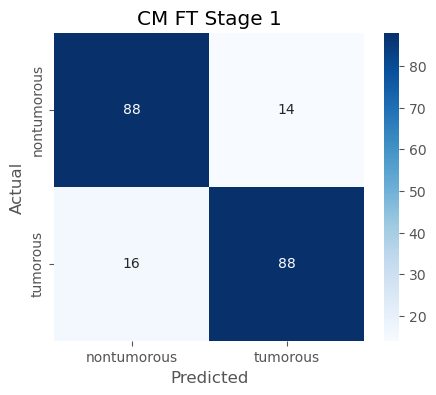

In [235]:
cm = confusion_matrix(y_true, y_pred2)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CM FT Stage 1")
plt.savefig("confusion_matrix_finetune1.png", dpi=300, bbox_inches="tight")
plt.show()

In [210]:
# Confusion matrix shows improvement especially with nontumerous accuracy from base model

In [124]:
model_03 = load_model("model_finetuned_stage1.h5")
# Unfreeze whole of Block 5
for layer in model_03.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True
    else:
        layer.trainable = False

In [126]:
# Learning rate decreased
adam3 = Adam(learning_rate=0.000005)
model_03.compile(optimizer=adam3, loss='categorical_crossentropy', metrics=['accuracy'])

In [128]:
cp = ModelCheckpoint(filepath="model_finetuned_stage2.h5", monitor='val_loss', verbose=1, save_best_only=True)

In [130]:
history_03 = model_03.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=10,  
    validation_data=valid_generator,
    callbacks=[es, cp, lrr]
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.7781
Epoch 1: val_loss improved from inf to 0.48059, saving model to model_finetuned_stage2.h5
10/10 [==============================] - 120s 12s/step - loss: 0.4390 - accuracy: 0.7781 - val_loss: 0.4806 - val_accuracy: 0.7476 - lr: 5.0000e-06
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.5142 - accuracy: 0.7312
Epoch 2: val_loss improved from 0.48059 to 0.44847, saving model to model_finetuned_stage2.h5
10/10 [==============================] - 115s 12s/step - loss: 0.5142 - accuracy: 0.7312 - val_loss: 0.4485 - val_accuracy: 0.7767 - lr: 5.0000e-06
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.7969
Epoch 3: val_loss improved from 0.44847 to 0.41393, saving model to model_finetuned_stage2.h5
10/10 [==============================] - 114s 12s/step - loss: 0.4629 - accuracy: 0.7969 - val_loss: 0.4139 - val_accuracy: 0.8107 - lr: 5.0000e

In [132]:
model_03 = load_model("model_finetuned_stage2.h5")

In [134]:
finetune2_valid_eval = model_03.evaluate(valid_generator)
finetune2_test_eval = model_03.evaluate(test_generator)

print(f'Validation Loss: {finetune2_valid_eval[0]}')
print(f'Validation Acc: {finetune2_valid_eval[1]}')
print(f'Testing Loss: {finetune2_test_eval[0]}')
print(f'Testing Acc: {finetune2_test_eval[1]}')

7/7 [==============================] - 43s 6s/step - loss: 0.3824 - accuracy: 0.8350
Validation Loss: 0.38589784502983093
Validation Acc: 0.8203883767127991
Testing Loss: 0.3824174702167511
Testing Acc: 0.8349514603614807


In [135]:
results_dict["validation"]["finetune2"] = finetune2_valid_eval
results_dict["test"]["finetune2"] = finetune2_test_eval

In [136]:
finetune2_prediction = model_03.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred3 = np.argmax(finetune2_prediction, axis=1)

7/7 [==============================] - 40s 6s/step


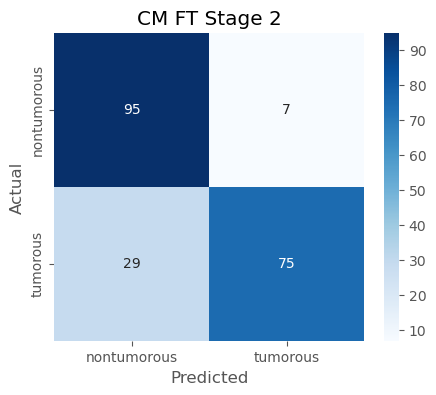

In [233]:
cm = confusion_matrix(y_true, y_pred3)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CM FT Stage 2")
plt.savefig("confusion_matrix_finetune2.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Great improvement in nontumorous accuracy but decreased tumorous accuracy

In [145]:
model_04 = load_model("model_finetuned_stage2.h5")
# Freeze Block 4 & 5
for layer in model_04.layers:
    if layer.name.startswith('block4') or layer.name.startswith('block5'):
        layer.trainable = True
    else:
        layer.trainable = False

In [147]:
# Learning rate decreased
adam4 = Adam(learning_rate=0.000002)
model_04.compile(optimizer=adam4, loss='categorical_crossentropy', metrics=['accuracy'])

In [149]:
cp = ModelCheckpoint(filepath="model_finetuned_stage3.h5", monitor='val_loss', verbose=1, save_best_only=True)

In [151]:
history_04 = model_04.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=10,  
    validation_data=valid_generator,
    callbacks=[es, cp, lrr]
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.4207 - accuracy: 0.8313 
Epoch 1: val_loss improved from inf to 0.35469, saving model to model_finetuned_stage3.h5
10/10 [==============================] - 156s 16s/step - loss: 0.4207 - accuracy: 0.8313 - val_loss: 0.3547 - val_accuracy: 0.8495 - lr: 2.0000e-06
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.3732 - accuracy: 0.8594 
Epoch 2: val_loss did not improve from 0.35469
10/10 [==============================] - 154s 16s/step - loss: 0.3732 - accuracy: 0.8594 - val_loss: 0.3593 - val_accuracy: 0.8252 - lr: 2.0000e-06
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.3774 - accuracy: 0.8344 
Epoch 3: val_loss did not improve from 0.35469
10/10 [==============================] - 154s 16s/step - loss: 0.3774 - accuracy: 0.8344 - val_loss: 0.3564 - val_accuracy: 0.8204 - lr: 2.0000e-06
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.3834 - accuracy: 

In [153]:
model_04 = load_model("model_finetuned_stage3.h5")

In [154]:
finetune3_valid_eval = model_04.evaluate(valid_generator)
finetune3_test_eval = model_04.evaluate(test_generator)

print(f'Validation Loss: {finetune3_valid_eval[0]}')
print(f'Validation Acc: {finetune3_valid_eval[1]}')
print(f'Testing Loss: {finetune3_test_eval[0]}')
print(f'Testing Acc: {finetune3_test_eval[1]}')

7/7 [==============================] - 42s 6s/step - loss: 0.3539 - accuracy: 0.8738
Validation Loss: 0.35702988505363464
Validation Acc: 0.8543689250946045
Testing Loss: 0.35386019945144653
Testing Acc: 0.8737863898277283


In [156]:
results_dict["validation"]["finetune3"] = finetune3_valid_eval
results_dict["test"]["finetune3"] = finetune3_test_eval

In [157]:
finetune3_prediction = model_04.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred4 = np.argmax(finetune3_prediction, axis=1)

7/7 [==============================] - 40s 6s/step


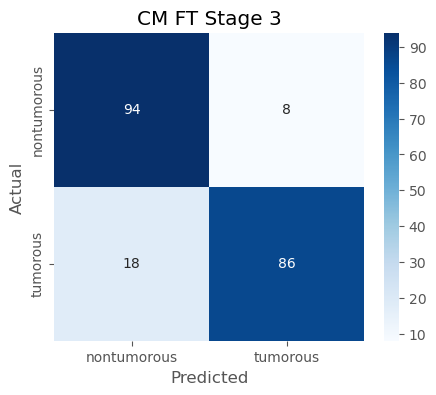

In [231]:
cm = confusion_matrix(y_true, y_pred4)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CM FT Stage 3")
plt.savefig("confusion_matrix_finetune3.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Tumorous accuracy back to more accurate

In [163]:
model_05 = load_model("model_finetuned_stage3.h5")

for layer in model_05.layers:
    layer.trainable = True

In [165]:
# Learning rate decreased
adam5 = Adam(learning_rate=0.000001)
model_05.compile(optimizer=adam5, loss='categorical_crossentropy', metrics=['accuracy'])

In [168]:
cp = ModelCheckpoint(filepath="model_final.h5", monitor='val_loss', verbose=1, save_best_only=True)

In [170]:
history_final = model_05.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=10, 
    validation_data=valid_generator,
    callbacks=[es, cp, lrr]
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.3680 - accuracy: 0.8406 
Epoch 1: val_loss improved from inf to 0.36168, saving model to model_final.h5
10/10 [==============================] - 253s 25s/step - loss: 0.3680 - accuracy: 0.8406 - val_loss: 0.3617 - val_accuracy: 0.8495 - lr: 1.0000e-06
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.8313 
Epoch 2: val_loss did not improve from 0.36168
10/10 [==============================] - 246s 25s/step - loss: 0.4218 - accuracy: 0.8313 - val_loss: 0.4003 - val_accuracy: 0.8204 - lr: 1.0000e-06
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8281 
Epoch 3: val_loss did not improve from 0.36168
10/10 [==============================] - 245s 25s/step - loss: 0.4135 - accuracy: 0.8281 - val_loss: 0.3735 - val_accuracy: 0.7864 - lr: 1.0000e-06
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8031 
Epo

In [172]:
model_05 = load_model("model_final.h5")

In [174]:
final_valid_eval = model_05.evaluate(valid_generator)
final_test_eval = model_05.evaluate(test_generator)

print(f'Validation Loss: {final_valid_eval[0]}')
print(f'Validation Acc: {final_valid_eval[1]}')
print(f'Testing Loss: {final_test_eval[0]}')
print(f'Testing Acc: {final_test_eval[1]}')

7/7 [==============================] - 45s 6s/step - loss: 0.3154 - accuracy: 0.8932
Validation Loss: 0.3622709810733795
Validation Acc: 0.8543689250946045
Testing Loss: 0.31536009907722473
Testing Acc: 0.893203854560852


In [175]:
results_dict["validation"]["final"] = final_valid_eval
results_dict["test"]["final"] = final_test_eval

In [176]:
final_prediction = model_05.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred5 = np.argmax(final_prediction, axis=1)

7/7 [==============================] - 45s 6s/step


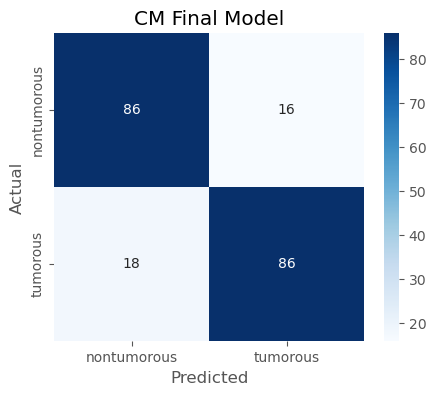

In [229]:
cm = confusion_matrix(y_true, y_pred5)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CM Final Model")
plt.savefig("confusion_matrix_final.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Decrease in nontumorous accuracy

# Saving data

In [183]:
import pickle

with open("fine_tuning_results.pkl", "wb") as f:
    pickle.dump(results_dict, f)

In [185]:
# Baseline model training was lost :(

with open("history_finetune_stage1.pkl", "wb") as f:
    pickle.dump(history_02.history, f)

with open("history_finetune_stage2.pkl", "wb") as f:
    pickle.dump(history_03.history, f)

with open("history_finetune_stage3.pkl", "wb") as f:
    pickle.dump(history_04.history, f)

with open("history_finetune_final.pkl", "wb") as f:
    pickle.dump(history_final.history, f)

In [213]:
# Function to load a history file
def load_history(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

# Load each saved history
history_finetune_stage1 = load_history("history_finetune_stage1.pkl")
history_finetune_stage2 = load_history("history_finetune_stage2.pkl")
history_finetune_stage3 = load_history("history_finetune_stage3.pkl")
history_finetune_final = load_history("history_finetune_final.pkl")

# Confirm successful loading
print("Loaded history files successfully!")

Loaded history files successfully!


In [219]:
# Load the saved dictionary
with open("fine_tuning_results.pkl", "rb") as f:
    results_dict = pickle.load(f)

# Verify the dictionary contents
print(results_dict)

{'validation': {'baseline': [0.5281327366828918, 0.737864077091217], 'finetune1': [0.4367676377296448, 0.8106796145439148], 'finetune2': [0.38589784502983093, 0.8203883767127991], 'finetune3': [0.35702988505363464, 0.8543689250946045], 'final': [0.3622709810733795, 0.8543689250946045]}, 'test': {'baseline': [0.4788374900817871, 0.8203883767127991], 'finetune1': [0.43337804079055786, 0.8300970792770386], 'finetune2': [0.3824174702167511, 0.8349514603614807], 'finetune3': [0.35386019945144653, 0.8737863898277283], 'final': [0.31536009907722473, 0.893203854560852]}}


# Analysis

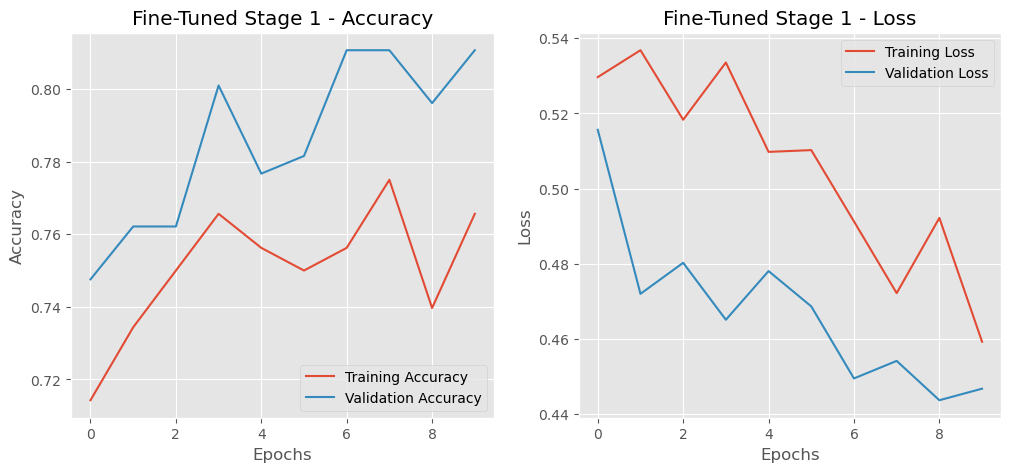

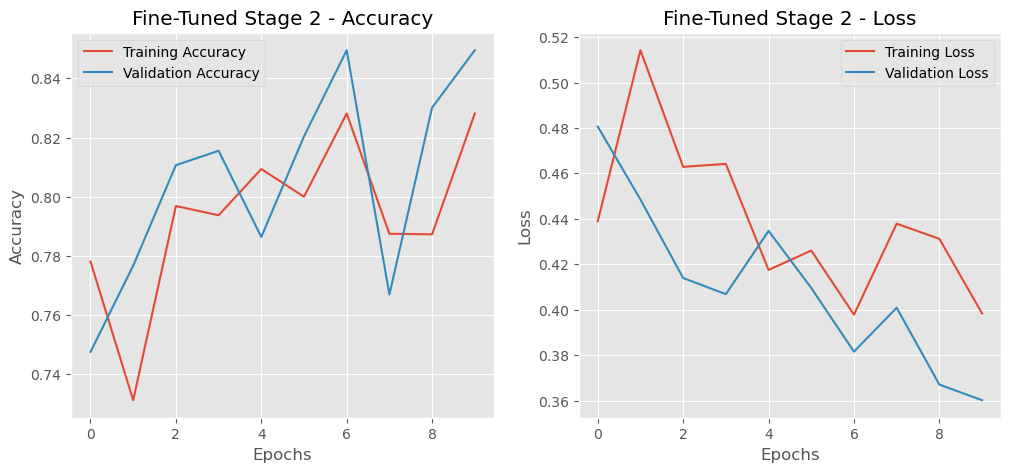

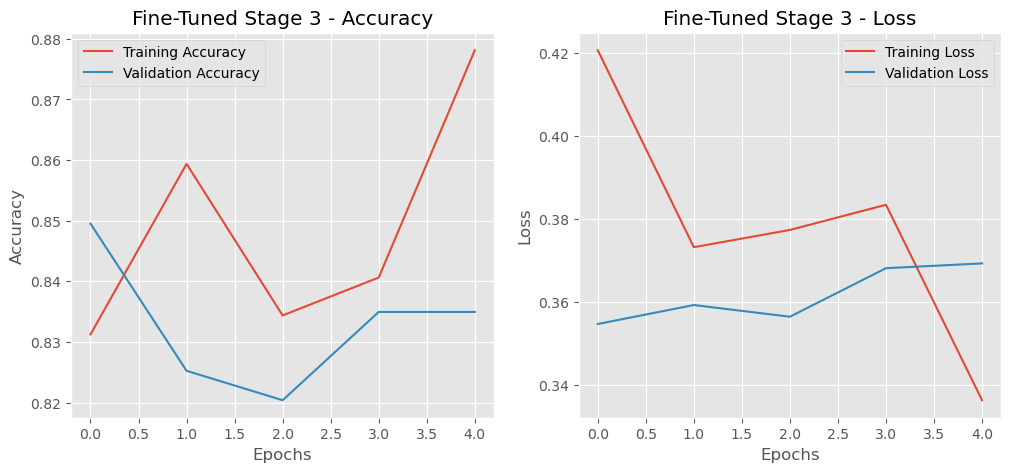

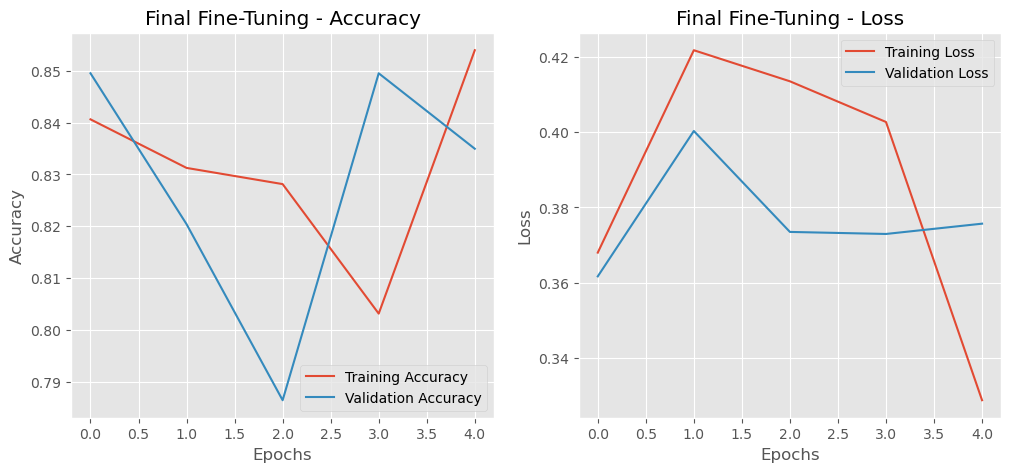

In [244]:
# Function to plot accuracy and loss curves
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')  # FIXED: No `.history`
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{title} - Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{title} - Loss')
    plt.savefig(f'{title}.png', dpi=300, bbox_inches="tight")
    plt.show()

# Plot Training History for Each Fine-Tuning Stage
plot_training_history(history_finetune_stage1, "Fine-Tuned Stage 1")
plot_training_history(history_finetune_stage2, "Fine-Tuned Stage 2")
plot_training_history(history_finetune_stage3, "Fine-Tuned Stage 3")
plot_training_history(history_finetune_final, "Final Fine-Tuning")

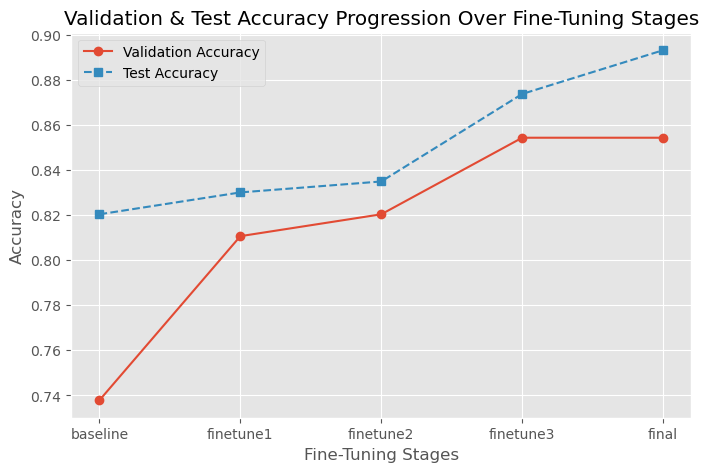

In [239]:
# Extract fine-tuning stages
stages = list(results_dict['validation'].keys())  # ['baseline', 'finetune1', 'finetune2', 'finetune3', 'final']

# Extract accuracy values for each stage
val_acc = [results_dict['validation'][stage][1] for stage in stages]  # Validation accuracy
test_acc = [results_dict['test'][stage][1] for stage in stages]  # Test accuracy

# Plot Validation & Test Accuracy Progression Over Fine-Tuning Stages
plt.figure(figsize=(8, 5))
plt.plot(stages, val_acc, marker='o', linestyle='-', label='Validation Accuracy')
plt.plot(stages, test_acc, marker='s', linestyle='--', label='Test Accuracy')

# Formatting the plot
plt.xlabel('Fine-Tuning Stages')
plt.ylabel('Accuracy')
plt.title('Validation & Test Accuracy Progression Over Fine-Tuning Stages')
plt.legend()
plt.grid(True)
plt.savefig('Val & Test Accuracy.png', dpi=300)
# Show the plot
plt.show()


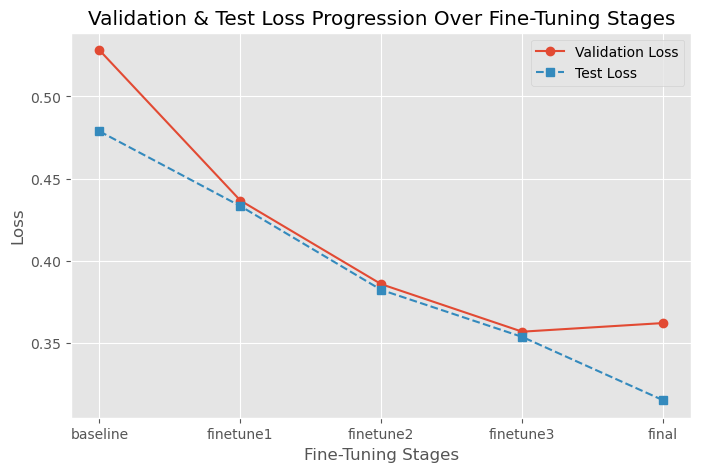

In [241]:
# Extract loss values for each stage
val_loss = [results_dict['validation'][stage][0] for stage in stages]  # Validation loss
test_loss = [results_dict['test'][stage][0] for stage in stages]  # Test loss

# Plot Validation & Test Loss Progression Over Fine-Tuning Stages
plt.figure(figsize=(8, 5))
plt.plot(stages, val_loss, marker='o', linestyle='-', label='Validation Loss')
plt.plot(stages, test_loss, marker='s', linestyle='--', label='Test Loss')

# Formatting the plot
plt.xlabel('Fine-Tuning Stages')
plt.ylabel('Loss')
plt.title('Validation & Test Loss Progression Over Fine-Tuning Stages')
plt.legend()
plt.grid(True)
plt.savefig('Val & Test Loss.png', dpi=300)
# Show the plot
plt.show()
